<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>



<div style="background-color:#f8f4ef; border-left:5px solid #d4b781ff; padding:12px 18px; border-radius:8px; font-family:sans-serif; font-size:14px; line-height:1.4; width: 720px;">

  <b style="color:#4b2e05;"> Index</b>

  <ol style="margin:8px 0 0 18px; padding:0;">
    <li style="color:#4b2e05;">Identifying Business Needs</li>
    <li style="color:#4b2e05;">Data Exploration and Preprocessing
      <ul style="margin:4px 0 4px 15px; list-style-type:circle;">
        ...
        <li style="color:#4b2e05;">2.11. Feature Selection</li>
        <ul style="margin:3px 0 3px 15px; list-style-type:square;">
            <li style="color:#4b2e05;">2.11.1. Filter Methods</li>
            <li style="color:#4b2e05;">2.11.2. Wrapper Methods</li>
            <li style="color:#4b2e05;">2.11.3. Embedded Methods</li>
          </ul>
      </ul>
    </li>
    <li style="color:#4b2e05;">Regression Benchmarking</li>
    <ul style="margin:4px 0 4px 15px; list-style-type:circle;">
        <li style="color:#4b2e05;">3.1.Regression Benchmarking</li>
        <li style="color:#4b2e05;">3.2. APAGAR</li>
    </ul>
    <li style="color:#4b2e05;">Open-Ended Section</li>
    
  </ol>
</div>



In [10]:
#APAGAR
#ANOVA
# Se forem dependentes, uma delas pode ser redundante, MAS NÃO QUER DIZER IMEDIATAMENTE QUE SÃO?
# Correto. A conclusão do teste $\mathbf{\chi^2}$ é a seguinte:Resultado do Teste: Se o $p$-value for baixo ($p < \alpha$), 
# as variáveis são estatisticamente dependentes (ou associadas).Implicação para ML (Redundância): A dependência estatística forte 
# sugere que as duas features transportam informação sobreposta (redundante). Por exemplo, a informação da Brand e da brand_model estão 
# intrinsecamente ligadas.A Decisão Humana: O teste $\mathbf{\chi^2}$ sinaliza a redundância, mas a decisão de remover uma feature é 
# sempre metodológica.Critério de Decisão: No seu caso, é uma boa prática manter a feature que é mais informativa e menos ambígua para o modelo. 
# Visto que a variável brand_model foi criada para ser a mais informativa (resolve ambiguidades), ela deve ser preferida sobre as variáveis mais 
# genéricas (Brand e model), se o teste $\chi^2$ mostrar forte dependência.

# ANOVA (Análise de Variância)
# Hipótese Nula ($H_0$): As médias da target contínua são iguais em todos os grupos (categorias). A variável categórica não é preditiva.
# Hipótese Alternativa ($H_a$): Pelo menos uma média de grupo é diferente das outras. A variável categórica é preditiva.
#     Pressupostos Chave (A Serem Cumpridos):
#     Normalidade: A target (price) deve seguir uma distribuição aproximadamente normal dentro de cada grupo.
#     Homogeneidade da Variância (Homoscedasticidade): A variância da target deve ser aproximadamente igual em todos os grupos. (Pode ser testado com o Teste de Levene).
#     Amostras Independentes: As observações são independentes.

#$$\mathbf{F} = \frac{\text{Variância Explicada (Variação Entre Grupos)}}{\text{Variância Não Explicada (Variação Dentro dos Grupos)}}$$



#CHI-SQUARED
# A. $\mathbf{\chi^2}$ (Teste de Independência Categórica)
# Hipótese Nula ($H_0$): As duas variáveis categóricas são independentes (não há relação entre elas).
# Hipótese Alternativa ($H_a$): As variáveis são dependentes (há uma relação).
#     Pressupostos Chave (A Serem Cumpridos):
#     Amostras Independentes: As observações (linhas) do seu dataset devem ser independentes. (Isto é geralmente assumido em dados tabulares).
#     Frequência Esperada: Nenhuma frequência esperada deve ser inferior a 5 (em $80\%$ das células da tabela de contingência, ou mais). Se esta condição falhar (o que é comum com categorias raras), deve-se usar o Teste Exato de Fisher ou colapsar categorias (o que já fez). Este é o pressuposto mais importante para verificar.

In [ ]:
#APAGAR
# 2. WRAPPER METHODS
# 2.1 TENHO RFE COM LR E COM RANDOMFOREST REGRESSOR
# 2.2. QUERO APROVEITAR E FAZER PLOT AQUI DESTE TIPO TANTO NO CASO LR QUANTO RANDOMFOREST:
# plt.plot(list(range(1,8)), train_score_list, label="Score on Training Set", color='yellowgreen')
# plt.plot(list(range(1,8)), val_score_list, label="Score on Validation Set", color='dimgray')
# plt.xlabel("Number of features")
# plt.ylabel("Score")
# plt.legend()
# plt.show()

# Não queremos ser nós a decidir o nr de features a escolher, deixamos o modelo decidir por nós
# ranking_, support_



# 3. EMBEDDING METHODS
# 3.1. LASSO E TAMBÉM RIDGE

# AQUI APLICAR ESTE PLOT EM VEZ DE IMPRIMIR OS VALORES DO COEF
# def plot_importance(coef,name):
#     imp_coef = coef.sort_values()
#     plt.figure(figsize=(8,10))
#     imp_coef.plot(kind = "barh")
#     plt.title("Feature importance using " + name + " Model")
#     plt.show()

# 3.2. QUERO TAMBÉM USAR - **Tree-based methods**: These methods use decision trees to calculate feature importance based on how much each feature contributes to reducing the impurity of the tree. Examples include Random Forest and Gradient Boosting.

### Import Libraries

In [12]:
#APAGAR: VER SE SÓ AQUI ESTÃO OS IMPORT E AQUELES NECESSÁRIO

# Standard library
from itertools import combinations

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# # Statistics                                   APAGAR: TEMOS DE USAR AS SUAS VERSÕES EM SKLEARN PARA FUNCIONAR COMO QUEREMOS
# from scipy import stats
# from scipy.optimize import minimize
# from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# Sklearn - Base
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

# Sklearn - Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression

# Sklearn - Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    ExtraTreesRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Sklearn - Metrics
from sklearn.metrics import (
    mean_absolute_error, 
    root_mean_squared_error, 
    mean_pinball_loss, 
    make_scorer
)

# Custom utilities
import utils

# MLxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


# Plot style
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']


### Load Data

In [13]:
# Load the preprocessed datasets (train, validation, test)
X_train = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train_df = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val_df   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")


# Set carID as index
X_train, X_val, X_test = [d.set_index('carID') for d in (X_train, X_val, X_test)]
# y_train, y_val = [d.set_index('carID') for d in (y_train_df, y_val_df)]                    #APAGAR
# Extract the target variable 'price_log' as a Series and ensure its index is 'carID'
y_train = y_train_df.set_index('carID')['price_log']
y_val = y_val_df.set_index('carID')['price_log']


print(f"Train: {X_train.shape[0]:,} rows, {X_train.shape[1]} features")
print(f"Val:   {X_val.shape[0]:,} rows")
print(f"Test:  {X_test.shape[0]:,} rows")

# palette colors
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']

Train: 60,768 rows, 36 features
Val:   15,193 rows
Test:  32,567 rows


<div style="background-color:#644712c5; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2.11 | Feature Selection</b></span>
    </h1>
</div>

#APAGAR
Explicar a importância de usar vários métodos de feature selection para não sermos bias (escrevi isso numa aula prática)

explicar que a nossa abordagem é mista porque por um lado temos muitas variáveis então queremo-nos livrar-nos o mais rápido possível de algumas delas (nas que acreditamos mesmo que não tenham relevância) mas depois deixar os outros métodos mais complexos (wrapper e embedded) fazerem o trabalho mais fino de selecionar as features mais relevantes de forma a não tirar logo e fazer uma seleção combinada 

A Feature Selection (FS) é um processo hierárquico. A nossa estratégia será:
**1.** Low Variance Filter: Remover todas as features com variância $\mathbf{\le 0.01}$.Remova features quase constantes que não conseguem separar amostras.
Ação 1: Remoção por Baixa Variância (Implementado)Variáveis Removidas: hasDamage, transmission_other, fuelType_electric, fuelType_other.Justificativa: Estas features têm variância $\le 0.01$ (e $0.00$ para hasDamage e transmission_other), o que indica que são quase constantes no dataset. São irrelevantes e adicionam ruído.
todas as variáveis com variância abaixo 0.01 foram imediatamente removidas
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other:


**2.** High Redundancy Filter --> Remover variáveis originais que são redundantes com features mais informativas (Target Encoded).Remover: Brand e brand_segment. (A informação de preço da marca está capturada em Brand_target_enc).
Ação 2: Remoção por Redundância MetodológicaVariáveis Removidas: Brand, brand_segment.Justificativa: Conforme o $\mathbf{\chi^2}$ indicou, estas features originais são redundantes. A sua informação de preço (segmento/média) está agora capturada de forma otimizada pelas features Target Encoded (Brand_target_enc). Removemos as originais para evitar multicolinearidade.


3. Univariate Relevance Filter-->Usar *f_classif* e *mutual_info_regression* no X_{final} para pontuar a relevância de cada feature restante em relação ao $log(price)$.--> Identificar as features mais fracas (piores p-values/pontuações MI mais baixas) que não contribuem para a previsão.
C. Ação 3: Remoção por Baixa Relevância (Análise do MI Score)Analisamos o DataFrame feature_scores (em anexo), ordenado pelo $\mathbf{MI\_Score}$ (que mede a relevância de forma robusta):
mpg_per_liter            $0.6747$MUITO ALTO. Excelente feature de engenharia (Eficiência), a manter.
brand_model_target_enc   $0.6688$MUITO ALTO. A feature mais preditiva sobre o preço da marca/modelo.
transmission_manual


NOTA: LOGO NA 1A PARTE LIVRAMO-NOS DE PAINTQUALITY PORQUE NÃO SERIA POSSÍVEL OBTER ESSE DADO ANTES DA AVALIAÇÃO DO CARROE AINDA YEAR E MODEL PORQUE CRIAMOS VARIÁVEIS QUE SÃO DIRETAMENTE DERIVADAS DESTAS


<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods</b></span>
    </h1>
</div>

##### **Variance Threshold**
APAGAR
O VarianceThreshold TESTE NÃO SUPERVISIONADO pode ser aplicado a qualquer variável numérica, independentemente da sua origem (seja contínua, binária ou codificada).
calcula a variância empírica. Se a variância for muito baixa (indicando que a feature tem quase o mesmo valor em todas as amostras), é removida.
Qualquer feature que apresente uma variância abaixo do limiar ($\mathbf{\text{threshold}}$) é considerada irrelevante para o modelo de previsão, independentemente da sua relação com o target ($\mathbf{y}$). 



APAGAR: sklearn.chi2 É PARA ESQUECER PORQUE TARGET TERIA SER CATEGÓRICO

In [16]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train)

# Get low variance columns and print them
low_variance = X_train.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train.columns.get_loc(col)]:.4f}")


# Drop low variance columns from all 
for d in [X_train, X_val , X_test]:
    d = d.drop(columns=low_variance, errors='ignore', inplace=True)

Number of features with variance closer to zero: 4
Features with variance closer to zero:
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other: 0.0022


##### **$\mathbf{\chi^2}$ Test**
O seu teste $\mathbf{\chi^2}$ (antes do encoding) confirma uma redundância extrema entre as variáveis categóricas originais.Pares Críticos de Violação ($\mathbf{low\_freq\_pct > 20\%}$):model / fuelType ($44.97\%$)transmission / fuelType ($36.67\%$)fuelType / brand_model ($47.29\%$)model / brand_model ($80.66\%$)model / transmission ($26.23\%$)

ANOVA. $\mathbf{f\_classif}$
O f_classif aplica o Teste ANOVA (Análise de Variância) univariado para cada feature ($\mathbf{X_i}$) em relação ao target ($\mathbf{y}$).Propósito: Procura determinar se a separação da variável target ($\mathbf{y}$) com base nos valores de uma determinada feature ($\mathbf{X_i}$) resulta em diferenças de média estatisticamente significativas.
Estatística $F$ para cada feature

$F$ alto: Indica que a variância entre as médias dos grupos (ex: a média de preço dos carros manuais vs. automáticos) é muito maior do que a variância dentro desses grupos (o ruído). A feature é preditiva.

Ideal para testar a relevância de flags criadas (ex: is_new_car) ou colunas OHE.
PARA VARIÁVEIS: 
- NÃO USAR PARA VAR NUMÉRICAS ( $\mathbf{f\_regression}$. é o teste t ou de correlação mais apropriado para features contínuas.)
- Variável Binária (0/1)
- Variáveis Categóricas OHE
- Variáveis Categóricas Target Encoded	Sim. (Tratadas como contínuas/discretas ordenadas).-> PODE NÃO SER O MELHOR PORQUE USOU A PRÓPRIA TARGET LOGO VAI ESTAR CORR. Target Encoded Feature ($\mathbf{X}_{\text{TE}}$): É altamente correlacionada com a média do $\mathbf{y}$ para esse grupo.Teste $\mathbf{f\_classif}$: Testa a diferença nas médias de $\mathbf{y}$ entre os grupos de $\mathbf{X}_{\text{TE}}$.O teste $\mathbf{f\_classif}$ sempre retornará um $p$-value muito baixo e um $F$ alto para uma feature Target Encoded, simplesmente porque a feature já é o próprio $\mathbf{y}$ (com algum ruído de smoothing).ACABA POR SER UM TESTE REDUNDANTE. A feature é relevante por construção.

O f_classif (ANOVA) é um teste paramétrico e, embora a sklearn não verifique os pressupostos, eles devem ser mitigados para garantir a validade dos $p$-values:
1. Normalidade do Target ($\mathbf{y}$): O target ($\mathbf{y}$) deve ser aproximadamente normal dentro de cada grupo.Sua Mitigação: Ao usar $\mathbf{\log(price)}$ como target (em vez do preço original enviesado), este pressuposto foi significativamente melhorado.

2. Homogeneidade da Variância: A variância do target deve ser aproximadamente igual em todos os grupos.
Sua Mitigação: A transformação logarítmica ajuda a estabilizar a variância. Para verificar o que resta, você usaria o Teste de Levene na escala logarítmica.

3. Amostras Independentes: Assumido (já que são carros individuais).
APAGAR
O $F$-statistic subestima a relevância total, porque a forte relação exponencial nos carros de luxo não é linear. Além disso, se a Normalidade residual for violada, o $p$-value é impreciso.

In [17]:
bin_variables = list(X_train.columns[X_train.nunique() == 2])

te_variables = ['Brand_target_enc', 'brand_model_target_enc']

# Colunas numéricas contínuas (que foram PowerTransformed)
continuous_features = [
    col for col in X_train.columns
    if col not in bin_variables
]

# Máscara Booleana para o mutual_info_regression
# True se a coluna for binária/discreta (OHE, flags)
discrete_mask = np.array([col in bin_variables for col in X_train.columns])

In [19]:
from sklearn.feature_selection import f_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler # Necessário apenas para o MI, devido à forma como o MI trata o input

# A. Mutual Information Regression (MI) - Método Não Paramétrico (Principal)
## O MI é robusto mas lento. Usamos n_neighbors=5.
mi_scores = mutual_info_regression(
    X_train.values,  # Usar X_train diretamente (já PowerTransformed/Scaled)
    y_train.values.ravel(), 
    discrete_features=discrete_mask,  # Aplica a máscara discreta
    n_neighbors=5,
    random_state=37,
    n_jobs=-1
)



# B. f_classif (ANOVA) - Método Paramétrico (Auxiliar)
f_stats, f_p_values = f_classif(X_train.values, y_train.values.ravel())


# C. Compilação dos Resultados
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': f_stats.round(2),
    'ANOVA_p_value': f_p_values.round(4),
    'MI_Score': mi_scores.round(4)
})

# Ordenar por MI Score (o mais alto é o mais relevante)
feature_scores = feature_scores.sort_values(by='MI_Score', ascending=False).reset_index(drop=True)

# Apresentação dos Resultados
print("\n=== Relevância Univariada (ANOVA e Informação Mútua) ===")
print("Pontuação MI: Maior valor = Mais Relevante (Melhor teste para o nosso Target)")
print("ANOVA p-value: Baixo (< 0.05) = Relevante")
pd.set_option('display.max_rows',None)
display(feature_scores)
pd.reset_option('display.max_rows')


=== Relevância Univariada (ANOVA e Informação Mútua) ===
Pontuação MI: Maior valor = Mais Relevante (Melhor teste para o nosso Target)
ANOVA p-value: Baixo (< 0.05) = Relevante


,Feature,F_Score,ANOVA_p_value,MI_Score
0,mpg_per_liter,5.14,0.0000,0.6747
1,brand_model_target_enc,10.77,0.0000,0.6688
2,model_popularity,1.72,0.0000,0.5879
3,tax_per_engine,1.22,0.0000,0.5444
4,mpg,2.58,0.0000,0.3936
5,engineSize,4.55,0.0000,0.3806
6,age_mileage_interaction,4.98,0.0000,0.3434
7,age,5.44,0.0000,0.3256
8,brand_popularity,1.34,0.0000,0.3222
9,Brand_target_enc,4.89,0.0000,0.3218


A decisão final de quais features remover deve ser uma combinação de evidência estatística (Pontuação MI) e justificação metodológica (Redundância e Domain Knowledge).

$\mathbf{mutual\_info\_regression}$
 é robusto e mede a dependência total entre as variáveis.
 mede a dependência entre $\mathbf{X}$ e $\mathbf{Y}$. Embora não teste a relação $\mathbf{X_i}$ vs. $\mathbf{X_j}$, é uma excelente métrica univariada de relevância que o ajuda a decidir o que manter.Regra: Se a feature A tem uma pontuação MI alta com o $\mathbf{Y}$ e a feature B também tem uma pontuação MI alta, e sabe por domain knowledge que são dependentes, você mantém a que tiver a pontuação MI mais alta.
 O $\mathbf{mutual\_info\_regression}$ mede o grau de dependência estatística entre a feature ($\mathbf{X_i}$) e o target ($\mathbf{y}$).Conceito: Procura a redução da incerteza sobre $\mathbf{y}$ que é obtida ao conhecer $\mathbf{X_i}$.
 $\mathbf{mutual\_info\_regression}$ mede a dependência total (linear e não linear).AO CONTRÁRIO DO ANOVA $\mathbf{f\_classif}$ mede apenas a relação linear entre as médias.

 O $\mathbf{mutual\_info\_regression}$ é o método da $\mathbf{sklearn}$ que melhor lhe permite medir a importância das suas features (Target Encoded, OHE, etc.) para o $\mathbf{\log(price)}$ sem pressupostos de normalidade.

 Pontuação = 0: As features são totalmente independentes.

Pontuação Alta: As features são altamente dependentes (relevantes).

O $\mathbf{mutual\_info\_regression}$ é ideal para o seu pipeline final ($\mathbf{X}_{\text{final}}$) porque é flexível e não paramétrico.

Tipo de Variável(X),            Pode ser Aplicado?,Pressupostos Específicos
1.Variável Numérica (Contínua),         Sim. (Após PowerTransform).,"Requer o parâmetro n_neighbors (vizinhos mais próximos) para estimar a densidade, que o seu código da sklearn já usa."
2.Variável Binária (0/1),              Sim.,Deve usar o parâmetro discrete_features=True (ou a mask de colunas binárias) para que a função trate corretamente estas features discretas.
3.Variável Categórica OHE,             Sim. (Tratada como binária).,Requer a definição de discrete_features=True.
4.Variável Categórica Target Encoded,  Sim. (Tratada como contínua).,Não requer o parâmetro discrete_features.


Hipóteses para o $\mathbf{mutual\_info\_regression}$O MI é um teste não paramétrico, o que é a sua maior vantagem:NÃO há pressupostos de Normalidade, Homogeneidade da Variância ou Relação Linear.Hipótese Nula ($H_0$): A feature ($\mathbf{X_i}$) é independente da target ($\mathbf{y}$).Você só precisa garantir que as suas variáveis contínuas são transformadas (PowerTransform) para melhorar a estabilidade e que as variáveis discretas (OHE/Flags) são sinalizadas corretamente usando o parâmetro discrete_features.


1-Use os resultados do $\mathbf{scipy.stats.chi2\_contingency}$ (teste de redundância $\mathbf{X_i}$ vs. $\mathbf{X_j}$) para justificar o que remover (e.g., Brand, brand_segment).
2- Use $\mathbf{mutual\_info\_regression}$ no seu $\mathbf{X_{\text{final}}}$ para obter as pontuações de relevância de todas as features restantes e confirmar o que manter.

Isto significa que o $\mathbf{mutual\_info\_regression}$ deve ser o seu padrão de referência (o teste principal), e o $\mathbf{f\_classif}$ (ANOVA) é apenas um auxiliar.


O $\mathbf{f\_classif}$ é bom para features binárias/OHE onde a relação é naturalmente linear (ou não existe). Para as suas features PowerTransformed e Target Encoded, onde as relações são complexas, o $\mathbf{mutual\_info\_regression}$ fornece uma medida de relevância total e mais fiável para a sua Feature Selection.

In [ ]:


#'mileage', 'tax', 'mpg', 'engineSize', 'previousOwners',
    #    'brand_price_std', 'brand_popularity', 'model_popularity', 'age',
    #    'miles_per_year', 'age_mileage_interaction',
    #    'premium_brand_engine_size_interaction', 'tax_per_engine',
    #    'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc',
    #    'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing',
    #    'year_is_missing', 'is_new_car', 'is_old_car', 'high_mileage',
    #    'low_mileage', 'transmission_manual', 'transmission_semi auto',
    #    'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol',
    #    'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range



#APAGAR
# bin_variables = ['mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 'is_new_car',
#  'is_old_car', 'high_mileage', 'low_mileage', 'transmission_manual', 'transmission_semi auto', 'transmission_unknown',
#  'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range']

#XXXXX
# numerical_variables = ['mileage', 'tax', 'mpg', 'engineSize', 'previousOwners', 'brand_price_std', 'brand_popularity',
# 'model_popularity', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction',
# 'tax_per_engine', 'mpg_per_liter']

# te_variables: ['Brand_target_enc', 'brand_model_target_enc']

#MARTA
#Variáveis que tirei:	'age_squared'
#ALTEREI NOME:   'model_mean_price' = brand_model_target_enc, 'brand_mean_price' = Brand_target_enc  (mas não é o mesmo que target encoder de brnad_model?)

In [ ]:
# ###APAGAR
# SelectFromModel: Meta-transformer for selecting features based on importance weights.

# SelectPercentile : Select features according to a percentile of the highest scores.

# SequentialFeatureSelector : Transformer that performs Sequential Feature Selection.

##### **Correlation Indices**

teste não paramétrico: É robusto a outliers e a distribuições não normais.
1. Variável Numérica (Contínua)       Sim. (Ex: $\mathbf{engineSize}$ vs. $\mathbf{\log(price)}$).A força da relação (o preço aumenta quando o motor aumenta, mesmo que a relação não seja perfeitamente reta).

2. Variável Binária (0/1)           Sim. (Tratada como ordinal/discreta).A correlação de postos é menos informativa aqui do que o ANOVA ou o MI.
3. Variável Target Encoded          Sim. (Tratada como ordinal).Mede a correlação entre a média de preço codificada e o $\mathbf{\log(price)}$ real.

Ambos são não paramétricos e robustos. O MI mede a dependência total (qualquer forma de relação), enquanto o Spearman mede apenas a dependência monótona (direção consistente). O MI é, teoricamente, uma medida de dependência mais completa.
O Spearman pode ser usado para complementar a Informação Mútua, especialmente para as features contínuas (após PowerTransform), para mostrar que a sua relação com o preço é forte e não linear.

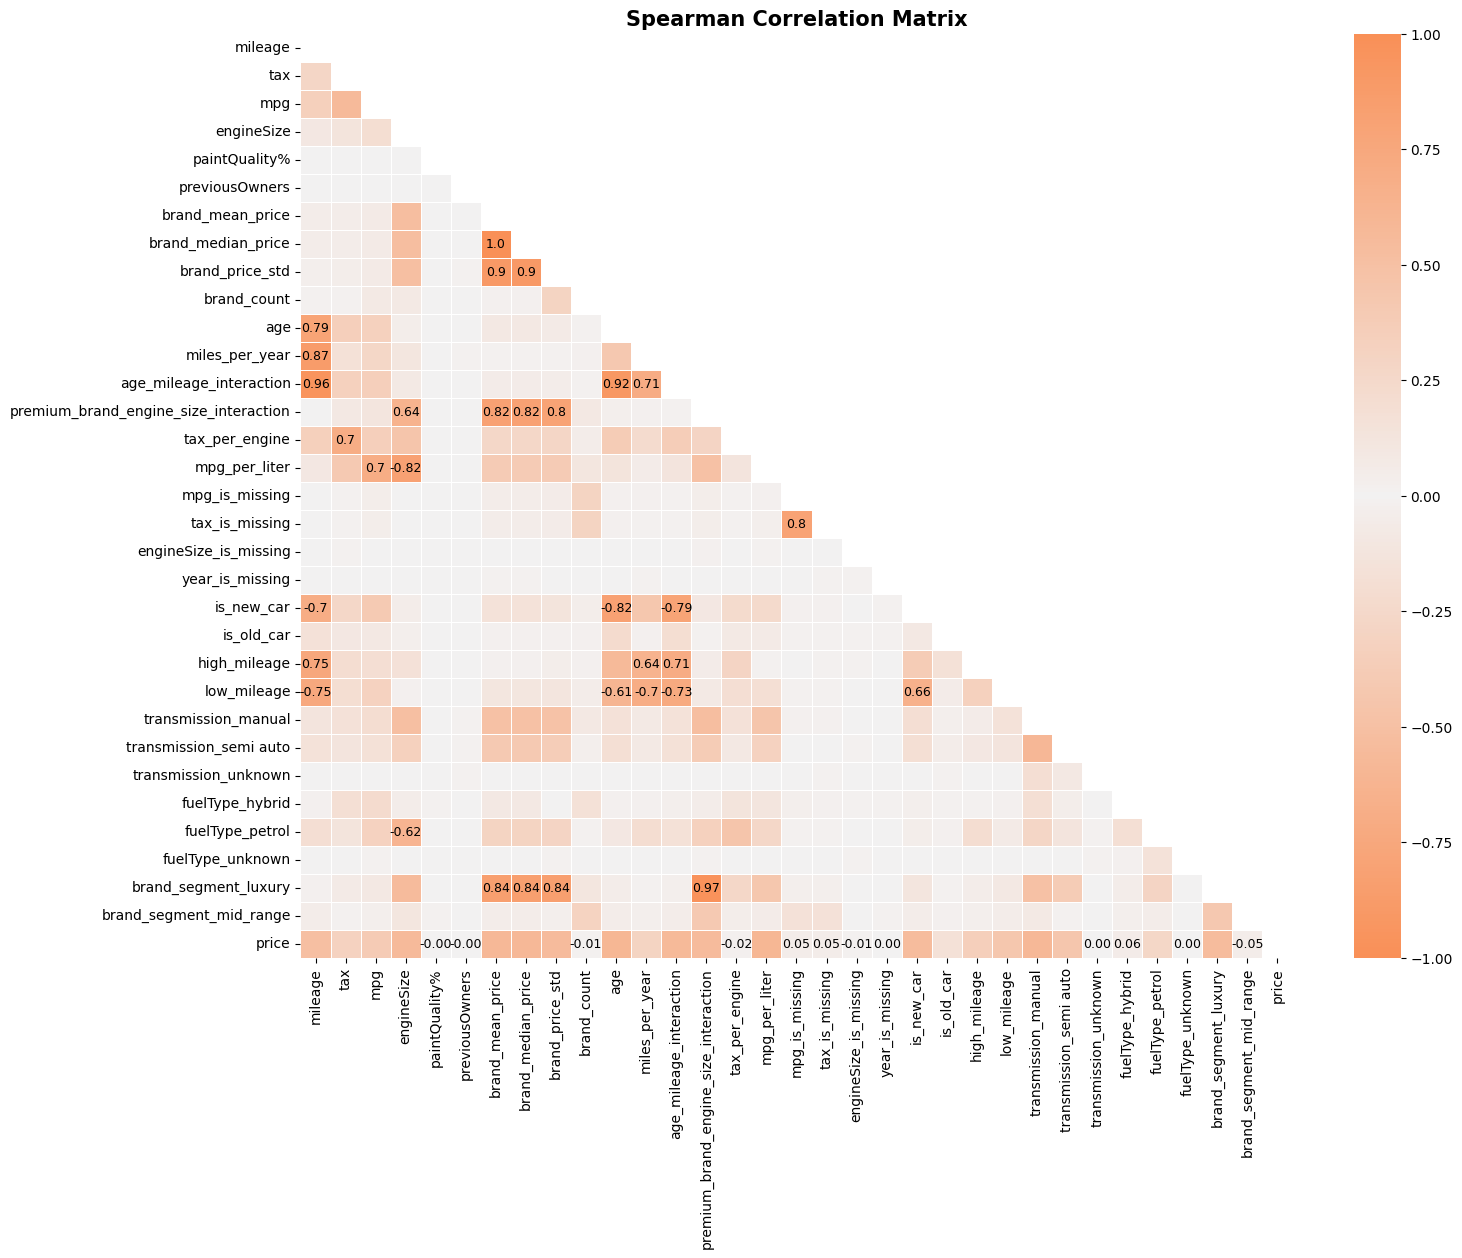

In [ ]:
# # Create a filtered DataFrame with only numeric and binary columns
# X_train_filtered = X_train[numerical_variables+bin_variables].copy()

# ##### Spearman Correlation ####
# cor = pd.concat([X_train_filtered, y_train], axis=1).corr(method='spearman').round(2)

# TARGET_COL = 'price'
# price_index = cor.columns.get_loc(TARGET_COL)

# # Create custom annotation matrix for weak correlations
# annot_matrix = np.full(cor.shape, "", dtype=object)
# for i, col in enumerate(cor.index):
#     corr_value = cor.loc[col, TARGET_COL]
#     # Annotate only if |corr| < 0.1
#     if abs(corr_value) < 0.1 and i != price_index:
#         annot_matrix[price_index, i] = f"{corr_value:.2f}"
        
# # Create main annotation matrix for strong correlations
# # Annotate only if |corr| >= 0.6
# mask_annot_main = np.absolute(cor.values) >= 0.6
# # Exclude 'price' row and column from this matrix
# mask_annot_main[:, price_index] = False
# mask_annot_main[price_index, :] = False
# annot_main = np.where(mask_annot_main, cor.values.astype(str), "")

# # Create the final annotation matrix by combining the two logics
# final_annot_matrix = annot_main.copy()
# for i in range(cor.shape[0]):
#     for j in range(cor.shape[1]):
#         # If the main annotation is empty and the weak one has a value, use the weak value
#         if final_annot_matrix[i, j] == "" and annot_matrix[i, j] != "":
#             final_annot_matrix[i, j] = annot_matrix[i, j]

# # Plotting
# plt.figure(figsize=(16, 12))

# # Create a custom diverging colormap based on orange tones
# cmap = sns.diverging_palette(h_neg=30, h_pos=30, s=90, l=70, n=256, center="light", as_cmap=True) 

# # Create a Mask to hide the upper triangle (to avoid redundancy)
# mask = np.zeros_like(cor, dtype=np.bool_)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(
#     data=cor,
#     mask=mask,
#     cmap=cmap,
#     annot=final_annot_matrix, # combined annotation matrix
#     fmt='s',                  # Format annotations as strings
#     vmin=-1, vmax=1, center=0,# Ensure the scale is from -1 to 1, centered at 0
#     linewidths=0.5,
#     annot_kws={"fontsize": 9, "color": "black"},
# )

# plt.title('Spearman Correlation Matrix', fontsize=15, fontweight='bold')
# plt.show()

Variável Numérica (Contínua)(TIPO ANOVA), mas use $\mathbf{f\_regression}$
sklearn.feature_selection.f_regression é o teste t ou de correlação mais apropriado para features contínuas.

##### **Statistical Hypothesis Testing**
###### **Chi Square Test**

In [20]:
mi_irrelevant_cols = [
    #'Brand',                  # Redundância Metodológica
    #'brand_segment',          # Redundância Metodológica
    'engineSize_is_missing',  # MI Score muito baixo
    'transmission_unknown',   # MI Score muito baixo
    'previousOwners',         # MI Score muito baixo
    'year_is_missing',        # MI Score muito baixo
    'fuelType_unknown'        # MI Score muito baixo
]
for d in [X_train, X_val, X_test]:
    d.drop(columns=mi_irrelevant_cols, errors='ignore', inplace=True)

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.2 |  Wrapper Methods</b></span>
    </h1>
</div>

##### **RFE**


In [13]:
def plot_rfe_scores(train_scores, val_scores, optimal_n, model_name):
    nof_list = np.arange(1, len(train_scores) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(nof_list, train_scores, label=f"MAE Train ({model_name})", color=palette[4])
    plt.plot(nof_list, val_scores, label=f"MAE Validation ({model_name})", color=palette[0])
    
    #vertical line at the optimal point
    plt.axvline(x=optimal_n, color='red', linestyle='--', label=f'Optimal (n={optimal_n})')
    
    plt.xlabel("Number of Features")
    plt.ylabel("MAE (Mean Absolute Error)")
    plt.title(f"RFE - Optimization of Number of Features ({model_name})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [14]:
def find_optimal_features_rfe(model, X_train, y_train, X_val, y_val):
    nof_list = np.arange(1, len(X_train.columns) + 1)
    low_score = float('inf')  # Start with an infinite value to find the minimum
    nof = 0
    train_score_list = []
    val_score_list = []

    print(f"Running RFE with model: {model.__class__.__name__}")

    for n in nof_list:
        # Use clone to ensure the model is "clean" in each iteration
        estimator = clone(model)
        
        rfe = RFE(estimator=estimator, n_features_to_select=n)
        X_train_rfe = rfe.fit_transform(X_train, y_train)
        X_val_rfe = rfe.transform(X_val)

        # Train the final model with the selected features
        estimator.fit(X_train_rfe, y_train)
        
        # Store the MAE scores
        train_pred = estimator.predict(X_train_rfe)
        train_mae = mean_absolute_error(y_train, train_pred)
        train_score_list.append(train_mae)
        
        val_pred = estimator.predict(X_val_rfe)
        val_mae = mean_absolute_error(y_val, val_pred)
        val_score_list.append(val_mae)

        # Check for the lowest validation error
        if val_mae <= low_score:
            low_score = val_mae
            nof = n

    print(f"Optimal number of features: {nof} with a validation MAE of {low_score:.4f}")

    # Train the final model with the optimal number of features to get the final feature list
    final_rfe = RFE(estimator=clone(model), n_features_to_select=nof)
    final_rfe.fit(X_train, y_train)
    selected_features_names = X_train.columns[final_rfe.support_].tolist()

    # Return all useful results
    return {
        'optimal_n': nof,
        'best_score': low_score,
        'selected_features': selected_features_names,
        'train_scores': train_score_list,
        'val_scores': val_score_list
    }

Running RFE with model: LinearRegression
Optimal number of features: 22 with a validation MAE of 2530.4478
LR Features (22): ['mileage', 'mpg', 'engineSize', 'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count', 'age', 'is_new_car', 'is_old_car', 'low_mileage', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc', 'transmission_manual', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown']



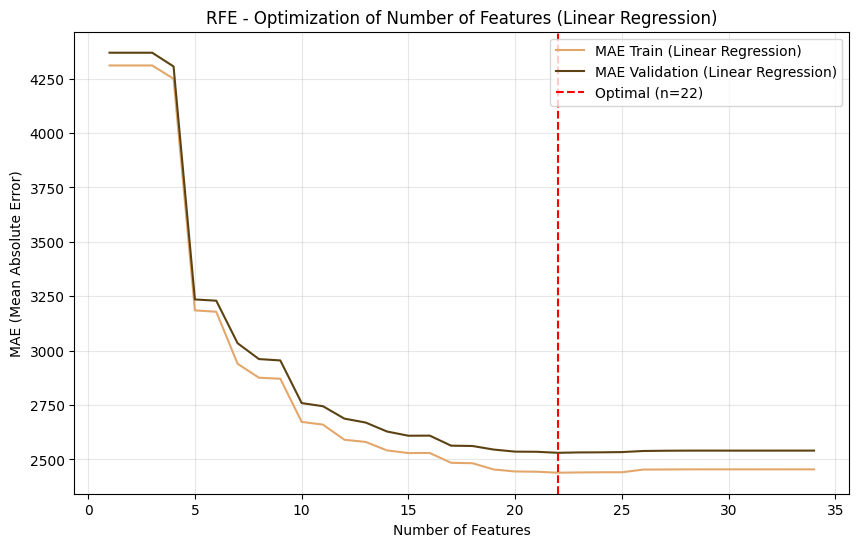

Running RFE with model: RandomForestRegressor
Optimal number of features: 33 with a validation MAE of 1374.9920
RF Features (33): ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count', 'age', 'is_new_car', 'is_old_car', 'miles_per_year', 'low_mileage', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc', 'transmission_manual', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range']


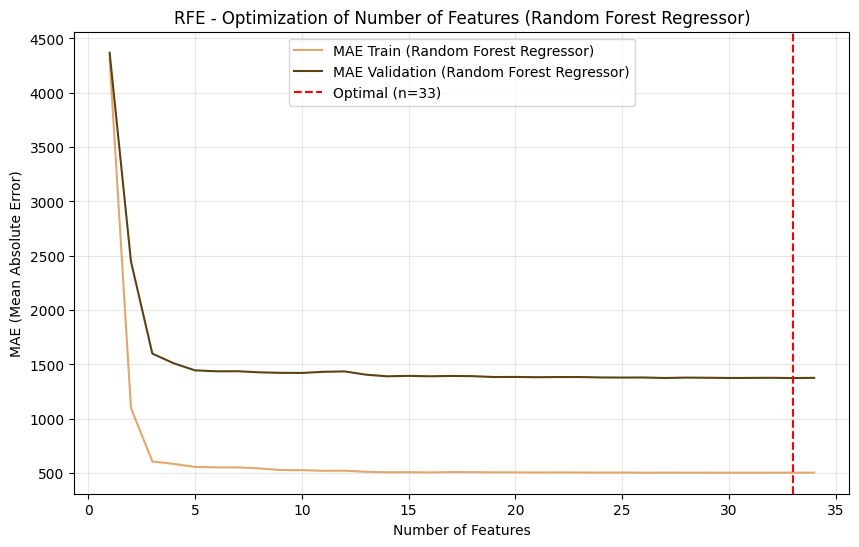

In [15]:
# RFE with Linear Regression optimized for MAE
lr_model = LinearRegression()
rfe_results_lr = find_optimal_features_rfe(lr_model, X_train, y_train, X_val, y_val)
print(f"LR Features ({rfe_results_lr['optimal_n']}): {rfe_results_lr['selected_features']}\n")
plot_rfe_scores(rfe_results_lr['train_scores'], rfe_results_lr['val_scores'], rfe_results_lr['optimal_n'], 'Linear Regression')

# RFE com RandomForest Regressor optimized for MAE
rf_model = RandomForestRegressor(n_estimators=50, random_state=37, n_jobs=-1)
rfe_results_rf = find_optimal_features_rfe(rf_model, X_train, y_train, X_val, y_val)
print(f"RF Features ({rfe_results_rf['optimal_n']}): {rfe_results_rf['selected_features']}")
plot_rfe_scores(rfe_results_rf['train_scores'], rfe_results_rf['val_scores'], rfe_results_rf['optimal_n'], 'Random Forest Regressor')

In [16]:
# # RFE with Linear Regression optimized for MAE
# lr_model = LinearRegression()
# rfe_results_lr = find_optimal_features_rfe(lr_model, X_train, y_train, X_val, y_val)
# print(f"Selected features ({rfe_results_lr['optimal_n']}): {rfe_results_lr['selected_features']}\n")
# plot_rfe_scores(rfe_results_lr['train_scores'], rfe_results_lr['val_scores'], rfe_results_lr['optimal_n'], 'Linear Regression')

# # RFE with RandomForest Regressor optimized for MAE
# rf_model = RandomForestRegressor(n_estimators=50, random_state=37, n_jobs=-1)
# rfe_results_rf = find_optimal_features_rfe(rf_model, X_train, y_train, X_val, y_val)
# print(f"Selected features ({rfe_results_rf['optimal_n']}): {rfe_results_rf['selected_features']}")
# plot_rfe_scores(rfe_results_rf['train_scores'], rfe_results_rf['val_scores'], rfe_results_rf['optimal_n'], 'Random Forest Regressor')

In [17]:
def find_optimal_features_forward_selection(model, X_train, y_train, X_val, y_val):
    # Inicialização das listas de scores e variáveis de controle
    all_features = list(X_train.columns)
    selected_features = []
    best_score = float('inf')
    optimal_n = 0
    train_score_list = [] # NOVO: Lista para scores de Treino
    val_score_list = []   # NOVO: Lista para scores de Validação
    
    # Loop de features (vamos adicionar features uma a uma)
    for i in range(len(all_features)):
        best_feature_to_add = None
        current_best_val_mae = float('inf')
        
        # Variáveis para armazenar o melhor MAE da iteração para o treino e validação
        best_train_mae_iter = float('inf')
        best_val_mae_iter = float('inf')
        
        # Testar cada feature não selecionada
        features_to_test = [f for f in all_features if f not in selected_features]
        
        # Parar se não houver mais features para testar (improvável devido ao range do loop)
        if not features_to_test:
            break

        # --- Sub-Loop para Encontrar a Melhor Feature Desta Iteração ---
        for feature in features_to_test:
            subset = selected_features + [feature]
            
            # 1. Treinar no X_train
            estimator = clone(model).fit(X_train[subset], y_train)
            
            # 2. Avaliar no X_val (Hold-out Validation)
            val_pred = estimator.predict(X_val[subset])
            val_mae = mean_absolute_error(y_val, val_pred)
            
            # 3. Avaliar no X_train (Para a curva de Treino)
            train_pred = estimator.predict(X_train[subset])
            train_mae = mean_absolute_error(y_train, train_pred)
            
            # Verificar se este subconjunto é o melhor subconjunto para esta iteração (Baseado no MAE de VALIDAÇÃO)
            if val_mae < current_best_val_mae:
                current_best_val_mae = val_mae
                best_feature_to_add = feature
                best_train_mae_iter = train_mae # Guarda o MAE de treino correspondente
                best_val_mae_iter = val_mae     # Guarda o MAE de validação correspondente
        
        # --- Fim do Sub-Loop ---

        # 4. Adicionar a melhor feature desta iteração
        # A condição de paragem é: a melhor feature encontrada NESTA iteração (current_best_val_mae)
        # não melhora o melhor MAE global (best_score) encontrado até agora.
        if best_feature_to_add is not None and best_val_mae_iter < best_score:
            
            # Atualiza o estado da seleção
            selected_features.append(best_feature_to_add)
            best_score = best_val_mae_iter
            optimal_n = len(selected_features)
            
            # REGISTO DE SCORES (CRUCIAL PARA O PLOT)
            train_score_list.append(best_train_mae_iter)
            val_score_list.append(best_val_mae_iter)
            
            print(f"Iteração {i+1}: Adicionada '{best_feature_to_add}'. Novo MAE Validação: {best_score:.4f}")
        else:
            # Parar se adicionar uma nova feature não melhorar o MAE de validação
            break
            
    print(f"\nSeleção Final: {optimal_n} features com MAE de validação de {best_score:.4f}")
    
    # NOVO RETORNO: Retorna as listas de scores para plotagem
    return {
        'optimal_n': optimal_n,
        'best_score': best_score,
        'selected_features': selected_features,
        'train_scores': train_score_list,
        'val_scores': val_score_list
    }

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.3 |  Embedded Methods</b></span>
    </h1>
</div>

In [ ]:

# --- Lasso Regularization (L1) ---
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
lasso_model.fit(X_train, y_train)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)
plot_importance_unified(abs(lasso_coefs), "Lasso (L1)", is_tree_model=False) 

# --- Ridge Regularization (L2) ---
ridge_model = Ridge(alpha=1.0, random_state=37)
ridge_model.fit(X_train, y_train)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns)
plot_importance_unified(abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 

# --- Random Forest ---
rf_model_emb = RandomForestRegressor(n_estimators=100, random_state=37, n_jobs=-1)
rf_model_emb.fit(X_train, y_train)
rf_importance = pd.Series(rf_model_emb.feature_importances_, index=X_train.columns)
plot_importance_unified(rf_importance, "Random Forest", is_tree_model=True) 

# --- Extra Trees Regressor ---
et_model = ExtraTreesRegressor(n_estimators=100, random_state=37, n_jobs=-1)
et_model.fit(X_train, y_train)
et_importance = pd.Series(et_model.feature_importances_, index=X_train.columns)
plot_importance_unified(et_importance, "ExtraTreesRegressor", is_tree_model=True)

In [ ]:
# O principal motivo para usar o ExtraTreesRegressor para Feature Selection é a sua capacidade de fornecer uma pontuação de Importância da Característica (Feature Importance), baseada na métrica Gini Importance

In [ ]:
# SPEARMAN
# paintQuality%              0.00
# previousOwners             0.00
# year_is_missing            0.00
# transmission_unknown       0.00
# fuelType_unknown           0.00
# brand_count                0.01
# engineSize_is_missing      0.01
# tax_per_engine             0.02
# mpg_is_missing             0.05
# tax_is_missing             0.05
# brand_segment_mid_range    0.05
# fuelType_hybrid  

Since we used 5 methods, we decided that the rule for variables that are not one-hot encoded (OHE) was to keep them if at least 4 out of the 5 methods suggested keeping them. For OHE variables, it was necessary that 4 methods recommended keeping them. Therefore, the following variables will be discarded: `paintQuality%`, `previousOwners`, `miles_per_year`, `transmission_semi auto`, `transmission_unknown`, `fuelType_hybrid`, `fuelType_petrol`, `fuelType_unknown`. The following table summarizes the decisions made for each variable:   

| Predictor            | Spearman  |RFE LR   | RFE RF   | Lasso    | Ridge    | What to do? | 
| ---                  | ---       |  ---    |   ---    |    ---   |  ---     |   ---       |
| mileage              |  Keep?    | Keep    | Keep     | Keep     | Keep     |  Keep       |  
| tax                  | Keep      | Keep    | Discard  | Keep     | Keep     |  Keep       |
| mpg                  | Keep      | Keep    | Keep     | Keep     | Keep     |  Keep       |
| engineSize           | Keep      | Keep    | Keep     | Keep     | Keep     |  Keep       |
| paintQuality%        | Discard   | Keep    | Discard  | Keep     | Keep     |  Discard    |
| previousOwners       | Discard   | Keep    | Discard  | Keep     | Keep     |  Discard    |
| age                  | Keep      | Keep    | Keep     | Keep     | Keep     |  Keep       |
| miles_per_year       | Discard   | Keep    | Discard  | Keep     | Keep     |  Discard    |
| Brand_freq_enc       | Discard   | Keep    | Keep     | Keep     | Keep     |  Keep       |
| brand_model_freq_enc | Keep      | Keep    | Keep     | Keep     | Keep     |  Keep       |
|transmission_manual   |  -        | Keep    | Keep     | Keep     | Keep     |  Keep       |
|transmission_semi auto|   -       | Keep    | Discard  | Keep     | Keep     |  Discard    |
|transmission_unknown  |-          | Keep    | Discard  | Keep     | Keep     |  Discard    |
|fuelType_hybrid       |-          | Keep    | Discard  | Keep     | Keep     |  Discard    |
|fuelType_petrol       |-          | Keep    | Discard  | Keep     | Keep     |  Discard    |
|fuelType_unknown      |-          | Keep    | Discard  | Keep     | Keep     |  Discard    |
<hr>

In [ ]:
#APAGAR: PARA O CÓDIGO DA MARTA 
##JÁ RETIREI:       PAINTQ, HASDAMAGE, fuelType_electric, fuelType_other, transmission_other

##EU RETIREI AINDA+:

##O QUE O AI ME DEU: 'Brand', 'brand_segment', ----'engineSize_is_missing', 'transmission_unknown', 'previousOwners', 'year_is_missing', 'fuelType_unknown',

##AINDA FALTA 'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing',

In [12]:
# Drop `paintQuality%`, `previousOwners`, `miles_per_year`, `transmission_semi auto`, `transmission_unknown`, `fuelType_hybrid`, `fuelType_petrol`, `fuelType_unknown`
X_train.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)
X_val.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)
X_test.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)

# <span style="color: #ffffff;">3 | Regression Benchmarking</span>

<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>


<br>
<div style="
  border: 2px solid #42A5F5;
  border-radius: 12px;
  background-color: #E3F2FD;
  padding: 14px;
  font-family: 'Segoe UI', sans-serif;
  color: #0D47A1;
  box-shadow: 2px 2px 8px rgba(33, 150, 243, 0.15);
">
  🚀 <b>O que é preciso:</b><br> 

- Explanation of model assessment **strategy** and **metrics** used
- **Optimization** efforts: presentation, results and discussion
- **Comparison** of performance between candidate models
 - Identify the type of problem and select the relevant algorithms.
 - Select one model assessment strategy to use throughout your work. Which metrics are you using to evaluate your model and why?
 - Train at least 1 model using the train dataset and obtain predictions for the test dataset.(Extra 1 point) Be on the Top-5 Best Groups in the Kaggle Competition
 - model assessment strategy (holdout, cross validation, etc...) and algorithms (minimum of 5 covered in class) used
 - rationale for choice of evaluation metric(s) and interpretation of results


APAGAR
</div>


In [ ]:
# EVALUATION FUNCTION 
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val, y_val_pred),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

# MODELS AND HYPERPARAMETER GRIDS
models_and_grids = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # Here we have no hyperparameters to tune
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=37),
        "params": {
            'alpha': [0.1, 1.0, 10.0],   # Regularization strength
            'l1_ratio': [0.1, 0.5, 0.9]  # Mix between L1 and L2
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'kernel': ['rbf'],
            'C': [1, 10, 100],      # Regularization parameter
            'gamma': ['scale', 'auto'] # Kernel coefficient
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=37),
        "params": {
            'max_depth': [5, 10, None], # Max depth to control overfitting
            'min_samples_leaf': [2, 5]  # Min samples per leaf
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [100],      # Number of trees
            'max_depth': [10, 20],      # Max depth of trees
            'min_samples_leaf': [2, 4, 6] # Min samples per leaf
        }
    },
    "K-Neighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [3, 5, 7],   # Number of neighbors
            'weights': ['uniform', 'distance'] # Weight function
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=37),        
        "params": {
            'learning_rate': [0.1],
            'max_depth': [3,7],
            'min_samples_leaf': [3,5],
            'n_estimators': [200],
            'subsample': [1.0, 0.8]
        }
    }
}


# MODEL TRAINING AND EVALUATION LOOP
results_list = []

# Iterate over each model defined in the dictionary
for model_name, config in models_and_grids.items():
    print(f"--- Processing model: {model_name} ---")
    param_grid = ParameterGrid(config['params'])
    best_model_results = None
    best_val_mae = float('inf')

    # Handle Linear Regression which has no grid
    if not list(param_grid):
        model = config['model']
        # Fit the model directly using X_train
        model.fit(X_train, y_train)
        scores = evaluate_model(model, X_train, y_train, X_val, y_val)
        best_model_results = {
            'Model': model_name,
            'Best Params': '{}',
            **scores
        }
    else:
        # Iterate over each combination of hyperparameters
        for params in param_grid:
            model = config['model']
            model.set_params(**params)
            
            # Fit the model directly using X_train
            model.fit(X_train, y_train)
            
            # Evaluate the model using the new evaluation function
            scores = evaluate_model(model, X_train, y_train, X_val, y_val)
            
            print(f"  Params: {params} -> Val MAE: {scores['Val MAE']:.4f}")
            
            # Store the best result based on validation MAE
            if scores['Val MAE'] < best_val_mae:
                best_val_mae = scores['Val MAE']
                best_model_results = {
                    'Model': model_name,
                    'Best Params': str(params),
                    **scores
                }
    
    results_list.append(best_model_results)
    print(f"Best validation MAE for {model_name}: {best_val_mae:.4f}\n")


# GET FINAL RESULTS
results_df = pd.DataFrame(results_list)

# Sort the results by validation MAE
results_df = results_df.sort_values(by='Val MAE', ascending=True)

# Reorder columns for better readability with the new metrics
columns_order = [
    'Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Train RMSE', 
    'Val Pinball (α=0.5)', 'Train Pinball (α=0.5)', 'Best Params'
]
results_df = results_df[columns_order]
display(results_df)

--- Processing model: Linear Regression ---
  Params: {} -> Val MAE: 3584.3732
Best validation MAE for Linear Regression: 3584.3732

--- Processing model: ElasticNet ---
  Params: {'alpha': 0.1, 'l1_ratio': 0.1} -> Val MAE: 3574.3183
  Params: {'alpha': 0.1, 'l1_ratio': 0.5} -> Val MAE: 3560.8787
  Params: {'alpha': 0.1, 'l1_ratio': 0.9} -> Val MAE: 3574.9216
  Params: {'alpha': 1.0, 'l1_ratio': 0.1} -> Val MAE: 4612.7643
  Params: {'alpha': 1.0, 'l1_ratio': 0.5} -> Val MAE: 4132.4925
  Params: {'alpha': 1.0, 'l1_ratio': 0.9} -> Val MAE: 3580.9394
  Params: {'alpha': 10.0, 'l1_ratio': 0.1} -> Val MAE: 6287.6545
  Params: {'alpha': 10.0, 'l1_ratio': 0.5} -> Val MAE: 5971.1202
  Params: {'alpha': 10.0, 'l1_ratio': 0.9} -> Val MAE: 4711.4814
Best validation MAE for ElasticNet: 3560.8787

--- Processing model: SVR ---
  Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -> Val MAE: 5439.0040
  Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} -> Val MAE: 5390.3855
  Params: {'C': 10, 'ga

,Model,Val MAE,Train MAE,Val RMSE,Train RMSE,Val Pinball (α=0.5),Train Pinball (α=0.5),Best Params
6,Gradient Boosting,1414.714125,1228.131137,2332.313310,1840.510040,707.357063,614.065568,"{'learning_rate': 0.1, 'max_depth': 7, 'min_sa..."
4,Random Forest,1425.652334,830.480952,2535.256951,1516.135196,712.826167,415.240476,"{'max_depth': 20, 'min_samples_leaf': 2, 'n_es..."
5,K-Neighbors,1632.203881,19.121401,2860.780896,189.414295,816.101940,9.560701,"{'n_neighbors': 7, 'weights': 'distance'}"
3,Decision Tree,1690.032022,1130.649342,2937.579784,2053.653981,845.016011,565.324671,"{'max_depth': None, 'min_samples_leaf': 5}"
2,SVR,2798.116590,2758.658422,4800.256846,4723.911399,1399.058295,1379.329211,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}"
1,ElasticNet,3560.878693,3491.782561,5451.197579,5323.794859,1780.439346,1745.891281,"{'alpha': 0.1, 'l1_ratio': 0.5}"
0,Linear Regression,3584.373188,3509.675604,5426.879092,5287.203839,1792.186594,1754.837802,{}


**Model Selection and Final Strategy**

Upon reviewing the model performance across our validation set, the **Support Vector Regressor (SVR)** emerged as the most robust model, achieving a Validation MAE of 2798.12 and a Training MAE of 2758.66. This was the smallest gap between these scores we achieved indicating this is the model with the least overfitting (but overfitting nonetheless), making the SVR the most reliable and generalizable model.

However, for the purpose of this Kaggle competition, where maximizing our leaderboard rank is one of the objectives, we are prioritizing the model with the best predictive performance on the validation set. In this regard, the **Gradient Boosting** model was the clear top performer, achieving a significantly lower **Validation MAE of 1414.71** (with a Training MAE of 1228.14). While this model shows a higher degree of overfitting compared to the SVR, its superior validation score makes it the strategic choice for our submission.

**Note**: To ensure a fair comparison, our methodology involved testing six distinct hyperparameter combinations for each algorithm, giving every model an equitable chance to find an optimal configuration.

We will now proceed by retraining our best Gradient Boosting model on the combined training and validation datasets. This will allow the model to learn from all available data before generating the final price predictions for the test set.


In [15]:
#Combining training and validation datasets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

print(f"Final training set dimensions (X): {X_train_full.shape}")
print(f"Final training set dimensions (y): {y_train_full.shape}")

# Train the Final Model with the Best Hyperparameters
best_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_samples_leaf': 3,
    'n_estimators': 200,
    'subsample': 1.0,
    'random_state': 37  # Add a random_state for reproducible results
}

# Instantiate the GradientBoostingRegressor with the best parameters
final_model = GradientBoostingRegressor(**best_params)

# Train the model on the full combined dataset
final_model.fit(X_train_full, y_train_full)

# Make Predictions on the Test Set
test_predictions = final_model.predict(X_test)

# Create and Export the Submission File
print("Creating the submission file...")
submission_df = pd.DataFrame({
    'carID': X_test.index,
    'price': test_predictions
})

# Export to a CSV file without the DataFrame index
submission_df.to_csv("./project_data/Group37_Version1.csv", index=False)
print("\nSubmission file 'Group37_Version1.csv' exported successfully!")
print("First 5 rows of the submission file:")
print(submission_df.head())

Final training set dimensions (X): (75956, 8)
Final training set dimensions (y): (75956,)
Creating the submission file...

Submission file 'Group37_Version1.csv' exported successfully!
First 5 rows of the submission file:
    carID         price
0   89856  11049.956294
1  106581  21575.734207
2   80886  12659.515303
3  100174  17039.134083
4   81376  24774.715679



<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>


<br>
<div style="
  border: 2px solid #42A5F5;
  border-radius: 12px;
  background-color: #E3F2FD;
  padding: 14px;
  font-family: 'Segoe UI', sans-serif;
  color: #0D47A1;
  box-shadow: 2px 2px 8px rgba(33, 150, 243, 0.15);
">
  🚀 <b>O que é preciso:</b><br> 

**Open-Ended Section**
 - Objectives for the Section and description of the actions taken <br>
 - Results and discussion of main findings → key takeaways
 Note: for example using a feature selection technique not covered in class on your regular pipeline is not sufficient, but explicitly comparing different feature sets would be. <br>

 Describe your strategy for the additional insights objective. This section is separated into different components:
- Formulation and Adequacy of the Objectives: 0.5v
-  Difficulty of tasks: 1v
- Correctness/efficiency of implementation: 1v
- Discussion of results: 1v


APAGAR
</div>

In [ ]:
#JUNTAR TUDO NO FINAL E FAZER UM MODELO COM TODOS OS DADOS
# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

In [ ]:
#APAGAR: Parte extra
# LINEAR REGRESSION
lr = LinearRegression()
lr.fit(X_train, y_train)
y_val_pred_lr = lr.predict(X_val)

# Save model as pickle file (save as compressed file - sav.gz)
import pickle
with open('./linear_regression_model.sav.gz', 'wb') as f:
    pickle.dump(lr, f)

#APAGAR: NO FIM É PRECISO ISTO PARA A APP
# Save model
with gzip.open('./project_data/linear_regression_model.sav.gz', 'wb') as f:
    joblib.dump(lr_model, f)